# Tutorial 5 — Perceptron


**Author:** [Vito Dichio](https://sites.google.com/view/vito-dichio/home),
Fellow in AI, ENS–PSL, Paris — ✉️ vito.dichio@psl.eu

**Course:** *Machine Learning: Theory and Applications*
Master in Cognitive Sciences, ENS–PSL — Fall 2025/26 (Lecturer: Simona Cocco)

**Format:** Practical Session (TD)

#### Bibliography:
[1] Rosenblatt, F. (1958). *The Perceptron: A probabilistic model for information storage and organization in the brain*. *Psychological Review*, 65(6), 386–408.

[2] LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). *Gradient-based learning applied to document recognition*. *Proceedings of the IEEE*, 86(11), 2278–2324.

[3] Bishop, C. M., & Bishop, H. (2023). Deep learning: Foundations and concepts. Springer Nature.

[4] Cocco et al., *From Statistical Physics to Data-Driven Modelling: with Applications to Quantitative Biology*, Oxford University Press (2022)



#### 🎯 **Goals**

- Understand the principles of **linear classification** for supervised learning.
- Implement the **Perceptron algorithm**, one of the earliest and simplest neural network models.
- Apply the Perceptron to the **MNIST handwritten digits** dataset and evaluate its performance.

###  **Context and data**


This tutorial introduces the **supervised learning** framework — a central paradigm in machine learning where a model learns to map inputs to known outputs from a set of labeled examples.
Formally, we are given a dataset of pairs
$$
\{(x^{(1)}, y^{(1)}), \dots, (x^{(N)}, y^{(N)})\},
$$
where each input $ x^{(n)} $ (e.g. an image) has an associated label $ y^{(n)} $ (e.g. the digit it represents).
The goal is to **learn a function** $ f_\theta(x) $ parameterized by weights $ \theta $ that predicts the correct label $ y $ for new, unseen inputs.

Within supervised learning, two main task types are typically distinguished:

- **Classification:** the output variable $ y $ is **discrete** (e.g. categories such as digit 0–9, or “awake” vs “asleep”).
- **Regression:** the output variable $ y $ is **continuous** (e.g. predicting a firing rate, temperature, or probability).

In this exercise, we focus on a **classification** task: learning to assign each image to one category (digits 0/1).

#### **The MNIST Dataset**

The **MNIST** (Modified National Institute of Standards and Technology) dataset [2] is one of the most iconic benchmarks in machine learning.
It consists of:
- **60,000 training images** and **10,000 test images** of handwritten digits from **0 to 9**.
- Each image is **28×28 pixels**, grayscale, and labeled with the correct digit.

MNIST is often considered the “Hello World” of image classification.
Its simplicity and balanced structure make it ideal for testing new algorithms -- from classical models like the Perceptron and logistic regression to deep convolutional networks [3].

Here, we will start from the simplest possible supervised task: classifying between **two digits only** (0 vs 1) using a simple **distance-based classifier** and the **Perceptron algorithm** [2].

The next cell will download and prepare the MNIST dataset for binary classification between digits 0 and 1.

In [3]:
import os
import numpy as np

if not os.path.isdir("mnist_data"):
    raise FileNotFoundError(
        "❌ The 'data' folder was not found. Please make sure you are in the correct working directory."
    )

def load_mnist_data(data_path, digits=None, verbose=False):
    """
    Load MNIST arrays from .npy files.

    Parameters
    ----------
    data_path : str
        Path to directory containing `mnist_x.npy` and `mnist_y.npy`.
    digits : None, int, tuple or list-like of ints, optional
        If None, return the full dataset.
        If an int, tuple, or list-like, return only the samples whose labels are in `digits`.
        Preferred form is a tuple, e.g. (0, 1).
    verbose : bool, optional
        If True, print shapes of the returned arrays.

    Returns
    -------
    tuple
        (images, labels)
        - images : ndarray, shape (N, 28, 28) for full dataset or (N_sub, 28, 28) for a subset
        - labels : ndarray, shape (N,) values 0-9 or (N_sub,) restricted to `digits`

    Raises
    ------
    FileNotFoundError
        If `mnist_x.npy` or `mnist_y.npy` are not found in `data_path`.
    TypeError
        If `digits` is not None and cannot be converted to a tuple of ints.
    """
    # Build file paths
    mnist_x_path = os.path.join(data_path, 'mnist_x.npy')
    mnist_y_path = os.path.join(data_path, 'mnist_y.npy')

    # Validate files exist
    if not os.path.exists(mnist_x_path) or not os.path.exists(mnist_y_path):
        raise FileNotFoundError(f"MNIST .npy files not found in {data_path}")

    # Load full MNIST arrays
    mnist_x = np.load(mnist_x_path)  # expected shape (70k, 28, 28)
    mnist_y = np.load(mnist_y_path)  # expected shape (70k,) values 0-9

    # If no digits specified, return full dataset
    if digits is None:
        ret_x, ret_y = mnist_x, mnist_y
    else:
        # Normalize digits argument to a tuple of ints (preferred form)
        if np.isscalar(digits):
            digits = (int(digits),)
        elif isinstance(digits, (list, tuple, np.ndarray)):
            digits = tuple(int(d) for d in digits)
        else:
            raise TypeError("`digits` must be None, an int, or an iterable of ints (e.g. (0, 1))")

        # Build mask for requested digits and return subset
        mask = np.isin(mnist_y, digits)
        ret_x = mnist_x[mask]
        ret_y = mnist_y[mask]

    if verbose:
        print(
            f"\n✅ Loaded dataset from `{data_path}`"
            f"\n X (images) shape : {ret_x.shape}"
            f"\n️ y (labels) shape: {ret_y.shape}"
        )

    return ret_x, ret_y

x_01, y_01 = load_mnist_data("mnist_data", digits=(0,1), verbose=True)


✅ Loaded dataset from `mnist_data`
 X (images) shape : (14780, 28, 28)
️ y (labels) shape: (14780,)


The following cell visualizes some examples of the digits 0 and 1 from the loaded dataset.

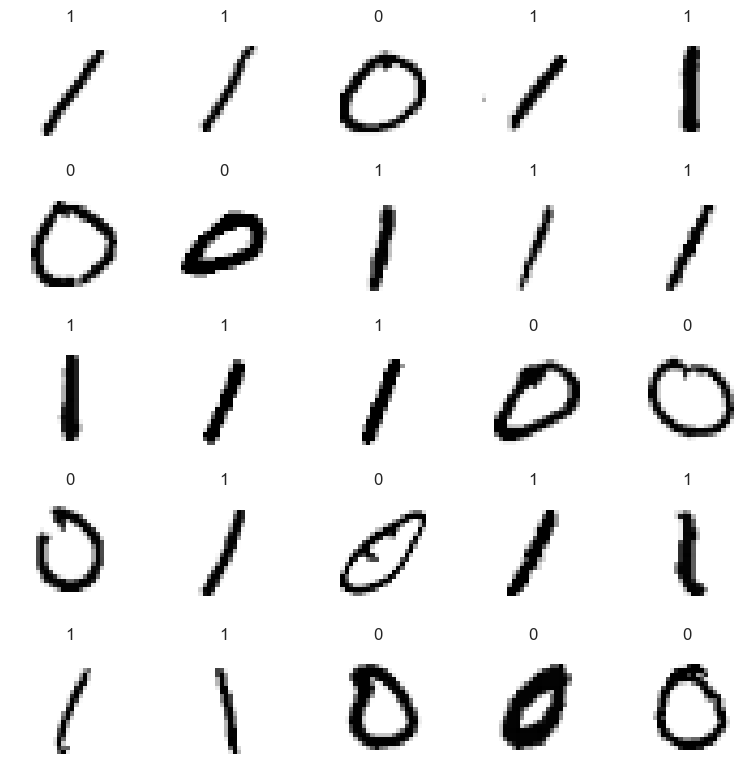

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = 1/2.54  # centimeters in inches

def plot_mnist_digits(x, y=None, start=0, randomise=False, seed=None, n=25):
    """
    Plot `n` images from `x` in a grid. By default plots 25 images in a 5x5 panel.

    Parameters
    ----------
    x : array-like, shape (N, 28, 28) or (N, n_features)
        Image array.
    y : array-like, optional
        Labels corresponding to images.
    start : int
        Index of first image to plot (ignored when randomize=True).
    randomise : bool
        If True select `n` random images.
    seed : int or None
        Random seed for reproducible selection.
    n : int
        Number of images to plot (default 16).
    """
    x = np.asarray(x)
    N = x.shape[0]

    # determine grid shape (try square-ish)
    nrows = int(np.floor(np.sqrt(n)))
    ncols = int(np.ceil(n / nrows))

    # select indices
    if randomise:
        rng = np.random.default_rng(seed)
        indices = rng.choice(N, size=n, replace=False)
    else:
        indices = np.arange(start, start + n) % N

    cm = 1/2.54  # centimeters in inches
    fig, axes = plt.subplots(nrows, ncols, figsize=(20*cm, 20*cm))
    axes = np.array(axes).flatten()

    for i, idx in enumerate(indices):
        ax = axes[i]
        if x.ndim == 3:
            img = x[idx]
        else:
            # assume flattened; try to reshape to 28x28 if possible
            try:
                img = x[idx].reshape(28, 28)
            except Exception:
                img = x[idx]
        ax.imshow(img, cmap=sns.color_palette("Grays", as_cmap=True))
        if y is not None:
            ax.set_title(f'{y[idx]}', fontsize=12)
        ax.axis('off')

    # turn off any unused subplots
    for j in range(len(indices), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_mnist_digits(x_01, y_01, randomise=True)

## 1 - Data Exploration and Visualization

Before building classifiers, we first need to **understand the data**. In this section, we will:
- Split the dataset into **training** and **test** sets
- Compute and interpret the **average image** for each class

The MNIST subset we will use contains **14,780 images** of handwritten digits *0* and *1*.
We will use the first **6/7** of the images for training and the remaining **1/7** for testing.


#### 🎯 Question 1a. Train/Test Split

Write a function that takes as input $f\in(0,1)$ and splits the data the arrays `x_01` and `y_01` into a **training set** (first fraction $ f $ of the samples and labels) and a **test set** (remaining fraction $ 1 - f$).

Store the results as:
- `x_01_train`, `y_01_train` -- training data and labels
- `x_01_test`, `y_01_test` -- test data and labels

#### 🎯 Question 1b. Computing Templates and distance

A simple way to understand what distinguishes the two classes is to compute their **average images** (also called *templates*).

Compute the average image for each digit:
$$
\boldsymbol{m}_0 = \frac{1}{N_0} \sum_{n | y^{(n)} = 0} \boldsymbol{x}^{(n)}, \quad
\boldsymbol{m}_1 = \frac{1}{N_1} \sum_{n | y^{(n)} = 1} \boldsymbol{x}^{(n)}
$$

where $N_0$ and $N_1$ are the number of training examples for each class. Store these as `m0` and `m1` -- both should have shape (28, 28). Then compute their **difference** -- which is also a matrix (28, 28) -- $$\boldsymbol{d} = \boldsymbol{m}_1 - \boldsymbol{m}_0\ .$$ Plot `m0`, `m1`, `d` side by side using `plt.imshow()` -- use the palette `RdBu` or `bwr` for `d`.

Interpretation:
- Positive values indicate pixels where digit 1 tends to be brighter than digit 0
- Negative values indicate pixels where digit 0 tends to be brighter than digit 1
- This difference vector $\boldsymbol{d}$ captures the **direction** in pixel space that best separates the two classes

#### 🎯 Question 1c. Flatten Images

Then, create **flattened versions** of the image arrays, reshaping each 28×28 image into a 784-dimensional vector:
- `x_train_flat` -- shape `(n_train, 784)`
- `x_test_flat` -- shape `(n_test, 784)`
- `d` -- shape `(784,)`

💡 *Hint:* Use the`.reshape()` method in NumPy. Each 28×28 image becomes a 1D vector of length 784.

Finally, print the shapes of all arrays to verify that your split is correct.

## 2 - Linear Classifier with Threshold Optimization

We have seen that the difference vector $\boldsymbol{d} = \boldsymbol{m}_1 - \boldsymbol{m}_0$ provides a natural direction for separating the two classes. In this section, we formalize this into a **linear classifier** and optimize its decision threshold.

#### **The Linear Classifier**

We have seen that the difference vector $\boldsymbol{d} = \boldsymbol{m}_1 - \boldsymbol{m}_0$ provides a natural direction for separating the two classes. In this section, we formalize this into a **linear classifier** and optimize its decision threshold.

This linear classifier will make predictions based on a simple rule:
$$
\hat{y}^{(n)} = \begin{cases}
1 & \text{if } \boldsymbol{d} \cdot \boldsymbol{x}^{(n)} > \theta \\
0 & \text{otherwise}
\end{cases}
$$

where $\theta$ is a **threshold** (also called **bias**), and $\boldsymbol{x}^{(n)}$ is the $n$-th training example. The classifier separates the input space into two regions using a **decision boundary**: the hyperplane where $\boldsymbol{d} \cdot \boldsymbol{x} = \theta$.

Note that $\boldsymbol{d} \cdot \boldsymbol{x}^{(n)} = \boldsymbol{m}_1 \cdot \boldsymbol{x}^{(n)} - \boldsymbol{m}_0 \cdot \boldsymbol{x}^{(n)}$, therefore the classifier effectively measures how much closer an input $\boldsymbol{x}^{(n)}$ is to the average image of class 1 versus class 0. The threshold $\theta$ determines where we draw the line between the two classes.

The key question is: **what is the optimal threshold $\theta^*$?**

#### 🎯 Question 2a. Computing the scores
Compute the **scores** for all training examples:
$$
s^{(n)} = \boldsymbol{x}^{(n)} \cdot \boldsymbol{d}
$$
Then, use the known train labels to plot a histogram of the scores for the two classes (0 and 1) using different colors.

#### 🎯 Question 2b. Linear Classifier and Classification Error

We now turn the score $ s = \boldsymbol{d} \cdot \boldsymbol{x} $ into an actual **decision rule** for classifying digits.

**2.b.i** / Write a function `linear_classifier_predict(x, d, theta)` that:
- Takes as input:
  - `x`: array of flattened images, shape (n_samples, 784)
  - `d`: direction vector, shape (784,)
  - `theta`: scalar threshold
- Returns:
  - `y_pred`: predicted labels (0 or 1), shape (n_samples,)

The prediction rule is: predict 1 if $\boldsymbol{d} \cdot \boldsymbol{x} > \theta$, else predict 0.

**2.b.ii** / To evaluate classifier performance, we need to measure how often it makes mistakes. Write a function `compute_error_rate(y_true, y_pred)` that takes true labels `y_true` and predicted labels `y_pred` and returns the **error rate** (fraction of mistakes):
$$
\text{Error} = \frac{1}{N} \sum_{n=1}^{N} 1 - \delta_{y_{\text{pred}}^{(n)}\ ,\ y_{\text{true}}^{(n)}}
$$
where $\delta_{a,b}$ is the Kroenecker function (1 if $a=b$, 0 otherwise).


**2.b.iii** / Using $\theta = 0$, compute and print the training error and test error.
Do these numbers tell you the classifier is working well?

#### 🎯 Question 2c. Finding the Optimal Threshold

The threshold $\theta$ is a hyperparameter we can optimize. We will search for the threshold that minimizes the training error.

**Algorithm**: Grid search for optimal threshold

1. Create an array `theta_values` of 200 evenly-spaced thresholds between the minimum and maximum projection scores on the training set
2. For each threshold in `theta_values`, compute the training error and store in an array `errors`
3. Find the optimal threshold: `theta_star = theta_values[np.argmin(errors)]`

#### 🎯 Question 2d. **Visualization and Reporting**.

Plot the training error as a function of $\theta$ with clear axis labels. Mark $\theta^*$ on the plot with a vertical dashed line.

Plot the histograms in (2.a) again, this time adding a vertical line at $\theta^*$ to visualize the decision boundary.

Compute and report the training and test error at $\theta^*$.

**Interpretation**: What shape does the error curve have? Why? How do the training and test errors at $\theta^*$ compare?

## 3 - The Perceptron Algorithm

So far, we have used a **fixed direction** $\boldsymbol{d} = \boldsymbol{m}_1 - \boldsymbol{m}_0$ derived from the class averages. While effective, this approach has limitations: it doesn't adapt to misclassified examples and it treats all training samples equally (no learning from mistakes).

The **Perceptron algorithm** [1], introduced by Frank Rosenblatt in 1958, addresses these issues through **iterative learning**. Instead of computing a fixed direction, the perceptron **learns** a weight vector $\boldsymbol{J}$ by repeatedly correcting its mistakes on the training data. See sec. 7.1 in [4].

#### **The Perceptron Learning Rule**

The core idea is simple: **whenever the classifier makes a mistake, adjust the weights to correct it**.

Let us assume that the labels are encoded as $y^{(m)} \in \{+1, -1\}$ for the two classes (e.g., +1 for digit 1 and -1 for digit 0). In the standard formulation, the perceptron must handle two cases separately:
- If $y^{(m)} = +1$ but $\boldsymbol{J} \cdot \boldsymbol{x}^{(m)} \leq 0$: add $\boldsymbol{x}^{(m)}$ to $\boldsymbol{J}$
- If $y^{(m)} = -1$ but $\boldsymbol{J} \cdot \boldsymbol{x}^{(m)} \geq 0$: subtract $\boldsymbol{x}^{(m)}$ from $\boldsymbol{J}$

Both cases can be unified by the update rule: $\boldsymbol{J} \leftarrow \boldsymbol{J} + y^{(m)} \boldsymbol{x}^{(m)}$.

#### **The Signed Pattern Formulation**

In this tutorial, we use an equivalent but more elegant formulation. We **pre-multiply each input by its label** to create **signed patterns**:
$$
\boldsymbol{\eta}^{(m)} = y^{(m)} \cdot \boldsymbol{x}^{(m)}
$$

**The key insight**: With this transformation, correct classification has a **single unified condition** for all patterns:
$$
\boldsymbol{J} \cdot \boldsymbol{\eta}^{(m)} > 0 \quad \text{(correct classification, regardless of class)}
$$

**Why?** The label sign automatically flips the direction:
- For $y^{(m)} = +1$: we need $\boldsymbol{J} \cdot \boldsymbol{x}^{(m)} > 0$, which is $\boldsymbol{J} \cdot \boldsymbol{\eta}^{(m)} > 0$ ✓
- For $y^{(m)} = -1$: we need $\boldsymbol{J} \cdot \boldsymbol{x}^{(m)} < 0$, which becomes $\boldsymbol{J} \cdot (-\boldsymbol{x}^{(m)}) > 0$, i.e., $\boldsymbol{J} \cdot \boldsymbol{\eta}^{(m)} > 0$ ✓

The perceptron's goal simplifies to: **find $\boldsymbol{J}$ with positive dot product with all signed patterns**.

#### **The Stability (Margin) Concept**

For each pattern $m$, we define its **stability** as:
$$
c^{(m)} = \boldsymbol{J} \cdot \boldsymbol{\eta}^{(m)}
$$

The stability measures how confidently pattern $m$ is classified:
- If $c^{(m)} > 0$: pattern is correctly classified
- If $c^{(m)} \leq 0$: pattern is **misclassified**

The **minimum stability** across all patterns is:
$$
c_{\min} = \min_{m=1,\dots,M} \boldsymbol{J} \cdot \boldsymbol{\eta}^{(m)}
$$

This represents the **worst-case pattern** -- the one that is misclassified or closest to being misclassified.

#### **The Perceptron Update Rule**

At each iteration, the algorithm:
1. Computes stabilities $c^{(m)} = \boldsymbol{J} \cdot \boldsymbol{\eta}^{(m)}$ for all patterns
2. Identifies the pattern $m_t$ with **minimum stability** (most violated)
3. Updates the weight vector:
$$
\boldsymbol{J}^{(t+1)} = \boldsymbol{J}^{(t)} + \boldsymbol{\eta}^{(m_t)}
$$

**Why does this work?** After the update, the stability of the selected pattern increases:
$$
\boldsymbol{J}^{(\text{new})} \cdot \boldsymbol{\eta}^{(m_t)} = \underbrace{(\boldsymbol{J}^{(\text{old})} + \boldsymbol{\eta}^{(m_t)})}_{\text{updated } \boldsymbol{J}} \cdot \boldsymbol{\eta}^{(m_t)} = \underbrace{\boldsymbol{J}^{(\text{old})} \cdot \boldsymbol{\eta}^{(m_t)}}_{\text{old stability}} + \underbrace{\|\boldsymbol{\eta}^{(m_t)}\|^2}_{> 0}
$$

The update **always improves** the classification of the most problematic pattern.

**Perceptron Convergence Theorem**: If the training data is **linearly separable**, the perceptron algorithm is guaranteed to converge to a solution (perfect classification) in a **finite number of steps**. This is remarkable: even though we're only fixing one pattern at a time, the algorithm eventually finds weights that classify **all** patterns correctly.

#### 🎯 Question 3a. Implementing the Basic Perceptron Algorithm

We will implement the perceptron in two stages: first a basic version, then add history tracking.

**Stage 1: Core Algorithm (without history tracking)**

Implement a function `perceptron_signed(X_train, y_train, max_updates=2000)` following this pseudocode:
```
Algorithm: Perceptron with Signed Patterns
──────────────────────────────────────────
Input: X_train (n_samples, n_features), y_train (n_samples) in {-1, +1}
Output: J (weight vector, normalized)

1. Re-label patterns y_train to {-1, +1} .

2. Create signed patterns:
   eta = y_train[:, None] * X_train    # shape (n_samples, n_features)

3. Initialize:
   J = zeros(n_features)
   n_updates = 0

4. Main loop (while n_updates < max_updates):
   a) Compute stabilities for all patterns:
      stabilities = eta @ J

   b) Find worst pattern (minimum stability):
      m_worst = argmin(stabilities)
      c_min = stabilities[m_worst]

   c) Perceptron update:
      J = J + eta[m_worst, :]
      n_updates += 1

   d) Optional: check convergence
      if c_min > 0 and all patterns classified correctly:
          break

5. Normalize final weights:
   J = J / ||J||

6. Return J, n_updates
```
Print the number of updates performed and verify that `J` has unit norm.

#### 🎯 Question 3b. Testing the Basic Perceptron

Run the perceptron algorithm on your training data with your **original labels** (0 and 1).

Using the weight vector `J` and your `linear_classifier_predict()` function from Section 2 (which predicts 0 or 1), compute and print the training and test error rates.

ℹ️ **Important Note**: The $\{-1, +1\}$ encoding is **only used internally during learning** to construct the signed patterns $\boldsymbol{\eta}^{(m)}$ and update the weights. Once training is complete, the learned weight vector $\boldsymbol{J}$ is simply a **direction in the 784-dimensional pixel space**, just like $\boldsymbol{d}$ was in Sections 1-2.

To make predictions, we use the same rule as before:
$$
\hat{y} = \begin{cases}
1 & \text{if } \boldsymbol{J} \cdot \boldsymbol{x} > 0 \\
0 & \text{otherwise}
\end{cases}
$$

The signed pattern formulation is a mathematical tool for **learning** the direction $\boldsymbol{J}$, but the final classifier is identical in form to the linear classifiers from Section 2.

#### 🎯 Question 3c. Visualizing Class Separation

Visualize how well the learned direction $\boldsymbol{J}$ separates the two classes.

Compute projection scores $\boldsymbol{J} \cdot \boldsymbol{x}$ for training and test data.

Plot overlapping histograms (normalized densities) for each class, marking the decision boundary at score = 0.

**Interpretation**:
- Are the classes perfectly separated in training data? In test data?
- Compare with Section 1d histograms (using $\boldsymbol{d} = \boldsymbol{m}_1 - \boldsymbol{m}_0$). Which direction achieves better separation?
- Does the test overlap match your test error rate?

#### 🎯 Question 3d. Adding History Tracking

To understand how the perceptron learns, we need to track its progress during training.

**Extend your `perceptron_signed()` function** to add history tracking. When `track_history=True`, record at each iteration:

1. Normalized minimum stability $c_{\min} / \|\boldsymbol{J}\|$ (track BEFORE the update):

2. **Training error** (track AFTER the update):
   - Use your `linear_classifier_predict()` and `compute_error_rate()` functions

Run the Perceptron learning with tracking enabled.

#### 🎯 Question 3e. Visualizing Convergence

Create two plots to understand how the perceptron learns over iterations: 1. Training error vs. iteration 2. Normalized minimum stability vs. iteration.

💡 *Hint*: Use `plt.xscale('log')` for logarithmic x-axis to see both early and late training dynamics.

**Interpretation questions**:
1. Does training error reach 0%? At approximately which iteration?
2. Does minimum stability become positive? What does this mean for classification?
3. Where does most learning happen: early iterations (< 100) or later (> 1000)?
4. What is the relationship between stability becoming positive and error reaching zero?